In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
import pdb
import pandas as pd
import random
import shutil

# pytorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.datasets import ImageFolder
from torchvision import models, transforms

# kornia imports
import kornia
import kornia.augmentation as K
import kornia.geometry.transform as T

In [2]:
seed = 211
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# Data augmentation and normalization for training
# Just normalization for validation and testing
# using Kornia
use_Kornia = False
if not use_Kornia:
    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomRotation(10),
            transforms.RandomHorizontalFlip(),
            transforms.RandomAffine(degrees=0, scale=(1.0, 1.1), shear=0),      # zoom
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'validation': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }

else:
    data_transforms = {
    "train": K.AugmentationSequential(
        K.RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.333)),
        K.RandomRotation(degrees=(-10, 10)),
        K.RandomHorizontalFlip(),
        K.RandomAffine(degrees=(0, 0), scale=(1.0, 1.1), shear=(0, 0)),  # Zoom
        # transforms.ToTensor(),
        K.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ),
    "validation": K.AugmentationSequential(
        K.Resize(size=(256, 256)),
        K.CenterCrop(size=(224, 224)),
        # transforms.ToTensor(),
        K.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ),
    "test": K.AugmentationSequential(
        K.Resize(size=(256, 256)),
        K.CenterCrop(size=(224, 224)),
        # transforms.ToTensor(),
        K.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    )
    }



In [3]:
def set_parameter_requires_grad(model, feature_extracting=False):

  if feature_extracting:
      # frozen model
      model.requires_grad_(False)
  else:
      # fine-tuning
      model.requires_grad_(True)

In [4]:
# for LoRA/DoRA
class LowRankLayer(nn.Module):
    def __init__(self, linear, rank, alpha, use_dora=True):
        super().__init__()
        # rank: controls the inner dimension of the matrices A and B; controls the number of additional parameters introduced by LoRA,
        # a key factor in determining the balance between model adaptability and parameter efficiency.
        # alpha: a scaling hyper-parameter applied to the output of the low-rank adaptation,
        # controls the extent to which the adapted layer's output is allowed to influence the original output of the layer being adapted.

        self.use_dora = use_dora
        self.rank = rank  # low-rank
        self.alpha = alpha  # scaling hyper-parameter
        self.linear = linear
        self.in_dim = linear.in_features
        self.out_dim = linear.out_features

        # weights
        std_dev = 1 / torch.sqrt(torch.tensor(self.rank).float())
        self.A = nn.Parameter(torch.randn(self.in_dim, self.rank) * std_dev)
        self.B = nn.Parameter(torch.zeros(self.rank, self.out_dim))

        if self.use_dora:
            self.m = nn.Parameter(
                self.linear.weight.norm(p=2, dim=0, keepdim=True))
        else:
            self.m = None

    def forward(self, x):
        lora = self.A @ self.B  # combine LoRA matrices
        if self.use_dora:
            numerator = self.linear.weight + self.alpha * lora.T
            denominator = numerator.norm(p=2, dim=0, keepdim=True)
            directional_component = numerator / denominator
            new_weight = self.m * directional_component
            return F.linear(x, new_weight, self.linear.bias)
        else:
            # combine LoRA with orig. weights
            combined_weight = self.linear.weight + self.alpha * lora.T
            return F.linear(x, combined_weight, self.linear.bias)

In [5]:
# find linear layers in the model
def find_linear_layers(model):
    linear_layers = []
    for name, module in model.named_children():
        if isinstance(module, nn.Linear):
            linear_layers.append(module)
        else:
            linear_layers.extend(find_linear_layers(module))
    return linear_layers

In [6]:
def replace_linear_with_dora_lora(model, rank, alpha, use_dora=True):
    for name, module in model.named_children():
        if isinstance(module, nn.Linear):
            # Create a new DoRALayer with the same dimensions
            in_features = module.in_features
            out_features = module.out_features
            if in_features > 10 and out_features > 10:
                # Replace the module with the LowRankLayer
                setattr(model, name,  LowRankLayer(module, rank, alpha, use_dora=use_dora))
        else:
            # Recursively apply this function to submodules
            replace_linear_with_dora_lora(module, rank, alpha, use_dora=use_dora)

In [7]:
def initialize_model(model_name = None, num_classes = 2, feature_extract = True, use_pretrained = True, DoRA = False, LoRA = False):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model = None
    weights = 'DEFAULT' if use_pretrained else None
    input_size = 224
    rank, alpha = 4, 8
    if model_name == "mobile net 2" or model_name == "MN_v2":
        model = models.mobilenet_v2(weights=weights)
        set_parameter_requires_grad(model, feature_extract)
        num_ftrs = model.classifier[1].in_features       # 1280
        model.classifier[1] = nn.Linear(num_ftrs, num_classes)  # replace the last FC layer
        if DoRA or LoRA:
            use_dora = True if DoRA else False
            replace_linear_with_dora_lora(model, rank, alpha, use_dora=use_dora)
        
    elif model_name == "mobile net 3 large" or model_name == "MN_v3_l":
        model = models.mobilenet_v3_large(weights=weights)
        set_parameter_requires_grad(model, feature_extract)
        num_ftrs = model.classifier[3].in_features       # 1280
        model.classifier[3] = nn.Linear(num_ftrs, num_classes)
        if DoRA or LoRA:
            use_dora = True if DoRA else False
            replace_linear_with_dora_lora(model, rank, alpha, use_dora=use_dora)

    elif model_name == "mobile net 3 small" or model_name == "MN_v3_s":
        model = models.mobilenet_v3_small(weights=weights)
        set_parameter_requires_grad(model, feature_extract)
        num_ftrs = model.classifier[3].in_features       # 1024
        model.classifier[3] = nn.Linear(num_ftrs, num_classes)
        if DoRA or LoRA:
            use_dora = True if DoRA else False
            replace_linear_with_dora_lora(model, rank, alpha, use_dora=use_dora)

    elif model_name == "squeezenet" or model_name == "SQN": # just to show 1X1 convolutional replacement instead of fully connected
        model = models.squeezenet1_0(weights=weights)
        set_parameter_requires_grad(model, feature_extract)
        # no fully connected layers - no need to replace them to use DoRA/LoRA
        model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1, 1), stride=(1, 1))
        model.num_classes = num_classes
        
    elif model_name == "resnet50" or model_name == "RN50":
        model = models.resnet50(weights=weights)
        set_parameter_requires_grad(model, feature_extract)        
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
        # no fully connected layers with a lot of parameters - no need to replace them to use DoRA/LoRA

    elif model_name == "vit base 16" or model_name == "VIT":     # visual transformer model
        model = models.vit_b_16(weights=weights)
        set_parameter_requires_grad(model, feature_extract)
        num_ftrs = model.heads[0].in_features
        model.heads[0] = nn.Linear(num_ftrs, num_classes)
    else:
        raise NotImplementedError

    return model, input_size 

In [8]:
data_dir = r'C:\Users\Data_Science\Documents\GitHub\deep-learn-project\input\dataset'   # change to your directory
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [9]:
class PILToTensor:
    def __init__(self):
        pass

    def __call__(self, image):
        return transforms.functional.to_tensor(image)

In [10]:
def create_dataloaders(batch_size = 32, data_dir = None):
    image_datasets = {x: ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'validation', 'test']}
    use_Kornia = False
    if use_Kornia:
        # convert image datasets from PIL to tensors
        print("Using Kornia")
        image_datasets['train'].transform = PILToTensor() 
        image_datasets['validation'].transform = PILToTensor()
        image_datasets['test'].transform = PILToTensor()
    train_loader = DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True, num_workers=4)
    # # print the type of the image and label in the train_loader
    # print(type(train_loader.dataset[0][0]), type(train_loader.dataset[0][1]))
    val_loader = DataLoader(image_datasets['validation'], batch_size=batch_size, shuffle=True, num_workers=4)
    test_loader = DataLoader(image_datasets['test'], batch_size=batch_size, shuffle=True, num_workers=4)
    dataloaders = {
        'train': train_loader,
        'val': val_loader,
        'test': test_loader
    }
    class_names = image_datasets['train'].classes
    return dataloaders, class_names


In [11]:
def apply_optimizer(model, feature_extract):
    params_to_update = model.parameters()
    print("Params to learn:")
    if feature_extract:
        params_to_update = []  # override the initial list definition above
        for name, param in model.named_parameters():
            if param.requires_grad == True:
                params_to_update.append(param)
                print("\t", name)
    else:
        for name, param in model.named_parameters():
            if param.requires_grad == True:
                print("\t", name)
    # Observe that all parameters are being optimized
    optimizer = torch.optim.SGD(params_to_update, lr=0.001, momentum=0.9)
    return optimizer

In [12]:
# training function
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()
    model = model.to(device)

    train_loss, train_acc, val_loss, val_acc = [], [], [], []
    history = [train_loss, train_acc, val_loss, val_acc]


    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        # zero the parameter gradients
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            # epoch statistics to numpy
            # epoch_loss = epoch_loss.numpy()
            epoch_acc = epoch_acc.cpu().numpy()

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'train':
                train_loss.append(epoch_loss), train_acc.append(epoch_acc)

                # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_loss.append(epoch_loss), val_acc.append(epoch_acc)
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    history = [train_loss, train_acc, val_loss, val_acc]

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history, time_elapsed          # time in seconds




In [13]:
# plot and save the best model
def plot_test_results(hist, title = ""):

    epochs = len(hist[0])

    fig, axes = plt.subplots(1, 2, figsize=(10, 6))

    axes[0].plot(range(1, epochs + 1), hist[0], label='Training')
    axes[0].plot(range(1, epochs + 1), hist[2], label='Validation')
    axes[0].set_xlabel('Epoch')
    axes[0].set_title('Loss')
    axes[0].legend(loc='best')


    axes[1].plot(range(1, epochs + 1), hist[1], label='Training')
    axes[1].plot(range(1, epochs + 1), hist[3], label='Validation')
    axes[1].set_xlabel('Epoch')
    axes[1].set_title('Accuracy')
    axes[1].legend(loc='best')
    
    fig.suptitle(title)

    plt.tight_layout()
    plt.show()


In [14]:
# MN_cnn_fe_models = ["mobile net 2", "mobile net 3 small", "mobile net 3 large", "squeezenet", "resnet50", "vit base 16"]
MN_cnn_fe_models = ["MN_v2_bz_32_ep_20_fe", 
                "MN_v3_s_bz_32_ep_20_fe", 
                "MN_v3_s_bz_64_ep_20_fe", 
                "MN_v3_s_bz_128_ep_20_fe",
                "MN_v3_l_bz_32_ep_20_fe",
                "RN50_bz_128_ep_20_fe",
                ]  # `fe` stands for `feature extraction', `ft` stands for `fine-tuning', `lora` stands for `LoRA', `dora` stands for `DoRA'

num_classes = 2
models_save_dir = r'C:\Users\Data_Science\Documents\GitHub\deep-learn-project\models'      # change to your directory
histories_save_dir = r'C:\Users\Data_Science\Documents\GitHub\deep-learn-project\histories'      # change to your directory

if not os.path.exists(models_save_dir):
    os.makedirs(models_save_dir)

if not os.path.exists(histories_save_dir):
    os.makedirs(histories_save_dir)
    
history_titles = ["train_loss", "train_acc", "val_loss", "val_acc"]

In [15]:
def train_and_save_model(model_descriptor):
    print("-------------------------------------------------------------------------------------------------------------------")
    print(f"Model descriptor: {model_descriptor}")
    print("\n")
    # Initialize the model for this run
    model_name = model_descriptor.split("_bz")[0]
    print(f"Model: {model_name}")
    batch_size = int(model_descriptor.split("_bz_")[1].split("_")[0])
    num_epochs = int(model_descriptor.split("_ep_")[1].split("_")[0])
    feature_extract = True if "fe" in model_descriptor else False
    DoRA = True if "dora" in model_descriptor else False
    LoRA = True if "lora" in model_descriptor else False

    model, input_size = initialize_model(model_name, num_classes=2, feature_extract=feature_extract, use_pretrained=True, DoRA=DoRA, LoRA=LoRA)
    print(f"Input size: {input_size}")
    print("\n")
    # Create the dataloaders
    dataloaders, class_names = create_dataloaders(batch_size=batch_size, data_dir=data_dir)

    # Send the model to device
    model = model.to(device)
    
    # Gather the parameters to be optimized/updated in this run. If we are
    #  finetuning we will be updating all parameters. However, if we are
    #  doing feature extract method, we will only update the parameters
    #  that we have just initialized, i.e. the parameters with requires_grad
    #  is True.
    optimizer = apply_optimizer(model, feature_extract)
    
    # Setup the loss fn
    criterion = nn.CrossEntropyLoss()

    # Train and evaluate
    model, history, model_time = train_model(model, dataloaders, criterion, optimizer, num_epochs=num_epochs)

    model_save_name = "model_" + model_descriptor + ".pth"
    model_save_path = os.path.join(models_save_dir, model_save_name)
    torch.save(model.state_dict(), model_save_path)
    
    # save the history in csv file with titles: train_loss, train_acc, val_loss, val_acc
    history_save_name = "history_" + model_descriptor + "_" + str(model_time) + ".csv"
    history_save_path = os.path.join(histories_save_dir, history_save_name)
    history_dict = {title: history[i] for i, title in enumerate(history_titles)}
    history_dict_df = pd.DataFrame(history_dict)
    history_dict_df.to_csv(history_save_path, index=False)
    
    print(f"Model saved at: {model_save_path}")
    print("\n")
    print("-------------------------------------------------------------------------------------------------------------------")
    print("\n")
    return model, optimizer, history, dataloaders

### CNN Models with Feature Extraction:

In [16]:
best_cnn_fe_model = None
best_cnn_fe_model_descriptor = None
best_cnn_fe_model_optimizer = None
best_cnn_fe_accuracy = 0.0

# Train the models
for model_descriptor in MN_cnn_fe_models:
    model, optimizer, history, dataloaders = train_and_save_model(model_descriptor)
    
    if best_cnn_fe_model is None:
        best_cnn_fe_model = model
        best_cnn_fe_model_descriptor = model_descriptor
        best_cnn_fe_model_optimizer = optimizer
        best_cnn_fe_accuracy = history[3][-1]
        best_cnn_fe_dataloader = dataloaders
    else:
        # if validation accuracy is better than the previous best model, update the best model
        if history[3][-1] > best_cnn_fe_accuracy:
            best_cnn_fe_model = model
            best_cnn_fe_model_descriptor = model_descriptor
            best_cnn_fe_model_optimizer = optimizer
            best_cnn_fe_accuracy = history[3][-1]
            best_cnn_fe_history = history
            best_cnn_fe_dataloader = dataloaders

-------------------------------------------------------------------------------------------------------------------
Model descriptor: MN_v2_bz_32_ep_20_fe


Model: MN_v2
Input size: 224


Params to learn:
	 classifier.1.weight
	 classifier.1.bias
Epoch 0/19
----------
train Loss: 0.7086 Acc: 0.4756
val Loss: 0.7016 Acc: 0.4804

Epoch 1/19
----------
train Loss: 0.6972 Acc: 0.5068
val Loss: 0.6878 Acc: 0.5588

Epoch 2/19
----------
train Loss: 0.6743 Acc: 0.5908
val Loss: 0.6764 Acc: 0.6275

Epoch 3/19
----------
train Loss: 0.6691 Acc: 0.5827
val Loss: 0.6623 Acc: 0.6961

Epoch 4/19
----------
train Loss: 0.6531 Acc: 0.6463
val Loss: 0.6488 Acc: 0.6863

Epoch 5/19
----------
train Loss: 0.6466 Acc: 0.6572
val Loss: 0.6501 Acc: 0.6765

Epoch 6/19
----------
train Loss: 0.6536 Acc: 0.6314
val Loss: 0.6379 Acc: 0.6863

Epoch 7/19
----------
train Loss: 0.6441 Acc: 0.6396
val Loss: 0.6338 Acc: 0.6863

Epoch 8/19
----------
train Loss: 0.6357 Acc: 0.6382
val Loss: 0.6242 Acc: 0.7059

Epoch 

### Best CNN Feature Extraction with LoRA and DoRA (if needed):

In [17]:
# check the best cnn model linear layers
use_lora_dora = False
linear_layers = find_linear_layers(best_cnn_fe_model)
print(f"Best CNN model: {best_cnn_fe_model_descriptor}")
print(f"Best CNN model linear layers: {linear_layers}")
# take out the in_features and out_features of the last linear layer
for layer in linear_layers:
    in_features = layer.in_features
    out_features = layer.out_features
    if in_features > 10 and out_features > 10:
        print("LoRA/DoRA can help in this layer")
        use_lora_dora = True
    else:
        print("LoRA/DoRA won't help much in this layer")
        

Best CNN model: MN_v3_s_bz_64_ep_20_fe
Best CNN model linear layers: [Linear(in_features=576, out_features=1024, bias=True), Linear(in_features=1024, out_features=2, bias=True)]
LoRA/DoRA can help in this layer
LoRA/DoRA won't help much in this layer


In [18]:
if use_lora_dora:
    best_cnn_fe_model_descriptor_with_lora = best_cnn_fe_model_descriptor + "_lora"
    best_cnn_fe_model_descriptor_with_dora = best_cnn_fe_model_descriptor + "_dora"

    # Train the best model with LoRA
    model_lora, optimizer_lora, history_lora, dataloaders_lora = train_and_save_model(best_cnn_fe_model_descriptor_with_lora)
    # Train the best model with DoRA
    model_dora, optimizer_dora, history_dora, dataloaders_dora = train_and_save_model(best_cnn_fe_model_descriptor_with_dora)

    # Check the best model with LoRA/DoRA
    if history_lora[3][-1] > best_cnn_fe_accuracy and history_lora[3][-1] > history_dora[3][-1]:
        # LoRA is better
        best_cnn_fe_model = model_lora
        best_cnn_fe_model_descriptor = best_cnn_fe_model_descriptor_with_lora
        best_cnn_fe_model_optimizer = optimizer_lora
        best_cnn_fe_accuracy = history_lora[3][-1]
        best_cnn_fe_history = history_lora
        best_cnn_fe_dataloader = dataloaders_lora
    elif history_dora[3][-1] > best_cnn_fe_accuracy and history_dora[3][-1] > history_lora[3][-1]:
        # DoRA is better
        best_cnn_fe_model = model_dora
        best_cnn_fe_model_descriptor = best_cnn_fe_model_descriptor_with_dora
        best_cnn_fe_model_optimizer = optimizer_dora
        best_cnn_fe_accuracy = history_dora[3][-1]
        best_cnn_fe_history = history_dora
        best_cnn_fe_dataloader = dataloaders_dora
else:
    print("skip LoRA/DoRA training on best CNN model")

-------------------------------------------------------------------------------------------------------------------
Model descriptor: MN_v3_s_bz_64_ep_20_fe_lora


Model: MN_v3_s
Input size: 224


Params to learn:
	 classifier.0.A
	 classifier.0.B
	 classifier.3.weight
	 classifier.3.bias
Epoch 0/19
----------
train Loss: 0.7031 Acc: 0.5515
val Loss: 0.6749 Acc: 0.6569

Epoch 1/19
----------
train Loss: 0.6758 Acc: 0.5691
val Loss: 0.6212 Acc: 0.6765

Epoch 2/19
----------
train Loss: 0.6632 Acc: 0.5962
val Loss: 0.6068 Acc: 0.6765

Epoch 3/19
----------
train Loss: 0.6346 Acc: 0.6396
val Loss: 0.6238 Acc: 0.6667

Epoch 4/19
----------
train Loss: 0.6319 Acc: 0.6396
val Loss: 0.6479 Acc: 0.6569

Epoch 5/19
----------
train Loss: 0.6018 Acc: 0.6640
val Loss: 0.6573 Acc: 0.6471

Epoch 6/19
----------
train Loss: 0.5996 Acc: 0.7019
val Loss: 0.6170 Acc: 0.6961

Epoch 7/19
----------
train Loss: 0.5823 Acc: 0.7222
val Loss: 0.5721 Acc: 0.7451

Epoch 8/19
----------
train Loss: 0.5781 Acc: 

### MN_v3_l or MN_v3_s Feature Extraction with LoRA and DoRA, if not the best CNN models so far

In [19]:
best_cnn_fe_model_name = best_cnn_fe_model_descriptor.split("_bz")[0]
if "MN_v2" not in best_cnn_fe_model_name and "MN_v3" not in best_cnn_fe_model_name:
    # find the best model with "MN_v2" or "MN_v3" using the history 
    MN_v3_or_MN_v2_cnn_fe_model = None
    MN_v3_or_MN_v2_cnn_fe_model_descriptor = None
    MN_v3_or_MN_v2_cnn_fe_accuracy = 0.0
    for model_descriptor in MN_cnn_fe_models:
        if "MN_v2" in model_descriptor or "MN_v3" in model_descriptor:
            # check if the history file exists
            # find a file with the model descriptor in the histories directory
            history_file_name = [f for f in os.listdir(histories_save_dir) if model_descriptor in f][0]
            # show all files in the directory
            if history_file_name not in os.listdir(histories_save_dir):
                continue
            history_path = os.path.join(histories_save_dir, history_file_name)
            history_df = pd.read_csv(history_path)
            if history_df.empty:
                continue
            last_val_acc = history_df["val_acc"].values[-1]
            if MN_v3_or_MN_v2_cnn_fe_model is None:
                MN_v3_or_MN_v2_cnn_fe_model = model_descriptor
                MN_v3_or_MN_v2_cnn_fe_accuracy = last_val_acc
                MN_v3_or_MN_v2_cnn_fe_model_descriptor = model_descriptor
                MN_v3_or_MN_v2_cnn_fe_dataloader = dataloaders
            if last_val_acc > MN_v3_or_MN_v2_cnn_fe_accuracy:
                MN_v3_or_MN_v2_cnn_fe_model = model_descriptor
                MN_v3_or_MN_v2_cnn_fe_accuracy = last_val_acc
                MN_v3_or_MN_v2_cnn_fe_model_descriptor = model_descriptor
                MN_v3_or_MN_v2_cnn_fe_dataloader = dataloaders

    print(f"MN_v3/MN_v2 best CNN model: {MN_v3_or_MN_v2_cnn_fe_model}")
    print(f"MN_v3/MN_v2 best CNN model descriptor: {MN_v3_or_MN_v2_cnn_fe_model_descriptor}")
    print(f"MN_v3/MN_v2 best CNN accuracy: {MN_v3_or_MN_v2_cnn_fe_accuracy}")
    
    # change the best one to LoRA/DoRA
    MN_v3_or_MN_v2_cnn_fe_model_descriptor_with_lora = MN_v3_or_MN_v2_cnn_fe_model_descriptor + "_lora"
    MN_v3_or_MN_v2_cnn_fe_model_descriptor_with_dora = MN_v3_or_MN_v2_cnn_fe_model_descriptor + "_dora"

    # Train the best one with LoRA
    model_lora, optimizer_lora, history_lora, dataloaders_lora = train_and_save_model(MN_v3_or_MN_v2_cnn_fe_model_descriptor_with_lora)
    # Train the best one with DoRA
    model_dora, optimizer_dora, history_dora, dataloaders_dora = train_and_save_model(MN_v3_or_MN_v2_cnn_fe_model_descriptor_with_dora)

    # Check the best one with LoRA/DoRA
    if history_lora[3][-1] > best_cnn_fe_accuracy and history_lora[3][-1] > history_dora[3][-1]:
        # LoRA is better
        print("LoRA is better than DoRA for " + MN_v3_or_MN_v2_cnn_fe_model_descriptor)
        print("and it performs better than the best CNN model with feature extraction " + best_cnn_fe_model_descriptor)
        best_cnn_fe_model = model_lora
        best_cnn_fe_model_descriptor = MN_v3_or_MN_v2_cnn_fe_model_descriptor_with_lora
        best_cnn_fe_model_optimizer = optimizer_lora
        best_cnn_fe_accuracy = history_lora[3][-1]
        best_cnn_fe_history = history_lora
        best_cnn_fe_dataloader = dataloaders_lora
    elif history_dora[3][-1] > best_cnn_fe_accuracy and history_dora[3][-1] > history_lora[3][-1]:
        # DoRA is better
        print("DoRA is better than LoRA for " + MN_v3_or_MN_v2_cnn_fe_model_descriptor)
        print("and it performs better than the best CNN model with feature extraction " + best_cnn_fe_model_descriptor)
        best_cnn_fe_model = model_dora
        best_cnn_fe_model_descriptor = best_cnn_fe_model_descriptor_with_dora
        best_cnn_fe_model_optimizer = optimizer_dora
        best_cnn_fe_accuracy = history_dora[3][-1]
        best_cnn_fe_history = history_dora
        best_cnn_fe_dataloader = dataloaders_dora
else: 
    print("The best CNN model is already MN_v2 or MN_v3")


The best CNN model is already MN_v2 or MN_v3


### Fine-Tuning on the Best CNN Model:

In [20]:
best_cnn_fe_model_name = best_cnn_fe_model_descriptor.split("_bz")[0]
print("The best model is: ", best_cnn_fe_model_name)
print("The best model descriptor is: ", best_cnn_fe_model_descriptor)
print("The best model accuracy is: ", best_cnn_fe_accuracy)

best_cnn_ft_model_descriptor = best_cnn_fe_model_descriptor.replace("fe", "ft")
print("The best model descriptor with fine-tuning is: ", best_cnn_ft_model_descriptor)

# train with fine-tuning
model_ft, optimizer_ft, history_ft, dataloaders_ft = train_and_save_model(best_cnn_ft_model_descriptor)
# check if fine-tuning is better
if history_ft[3][-1] > best_cnn_fe_accuracy:
    print("Fine-tuning is better")
    best_cnn_ft_model = model_ft
    best_cnn_ft_model_descriptor = best_cnn_ft_model_descriptor
    best_cnn_ft_model_optimizer = optimizer_ft
    best_cnn_ft_accuracy = history_ft[3][-1]
    best_cnn_ft_history = history_ft
    best_cnn_ft_dataloader = dataloaders_ft
else:
    print("Fine-tuning is not better, keep with your best model")
    print("The best model is: ", best_cnn_fe_model_name)
    

The best model is:  MN_v3_s
The best model descriptor is:  MN_v3_s_bz_64_ep_20_fe
The best model accuracy is:  0.7352941176470588
The best model descriptor with fine-tuning is:  MN_v3_s_bz_64_ep_20_ft
-------------------------------------------------------------------------------------------------------------------
Model descriptor: MN_v3_s_bz_64_ep_20_ft


Model: MN_v3_s
Input size: 224


Params to learn:
	 features.0.0.weight
	 features.0.1.weight
	 features.0.1.bias
	 features.1.block.0.0.weight
	 features.1.block.0.1.weight
	 features.1.block.0.1.bias
	 features.1.block.1.fc1.weight
	 features.1.block.1.fc1.bias
	 features.1.block.1.fc2.weight
	 features.1.block.1.fc2.bias
	 features.1.block.2.0.weight
	 features.1.block.2.1.weight
	 features.1.block.2.1.bias
	 features.2.block.0.0.weight
	 features.2.block.0.1.weight
	 features.2.block.0.1.bias
	 features.2.block.1.0.weight
	 features.2.block.1.1.weight
	 features.2.block.1.1.bias
	 features.2.block.2.0.weight
	 features.2.block.2

-------------------------------------------------------------------------------------------------------------------
Model descriptor: MN_v2_bz_32_ep_20_fe


Validation accuracy: 0.70


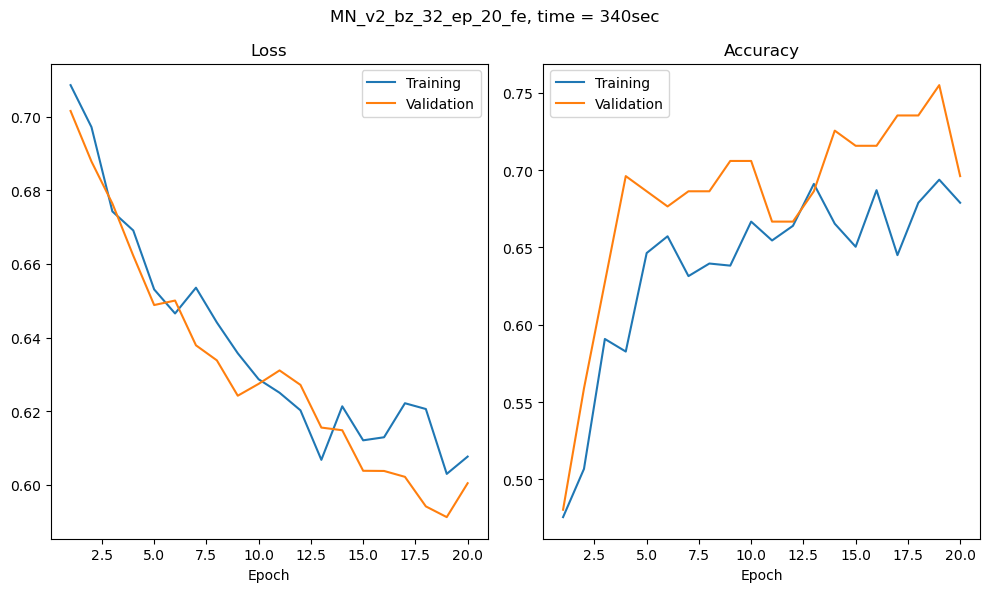

-------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------
Model descriptor: MN_v3_l_bz_32_ep_20_fe


Validation accuracy: 0.68


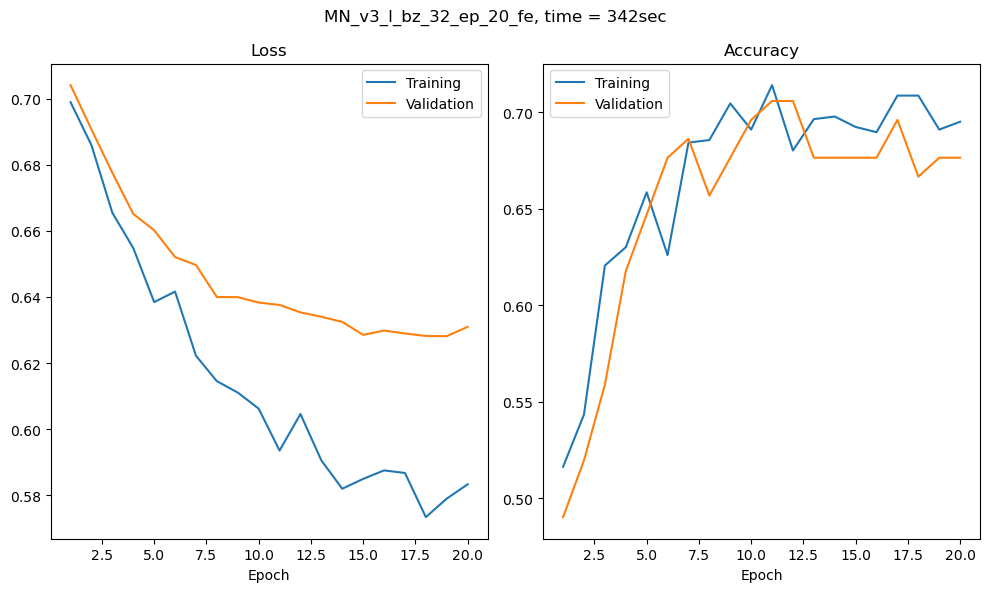

-------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------
Model descriptor: MN_v3_s_bz_128_ep_20_fe


Validation accuracy: 0.71


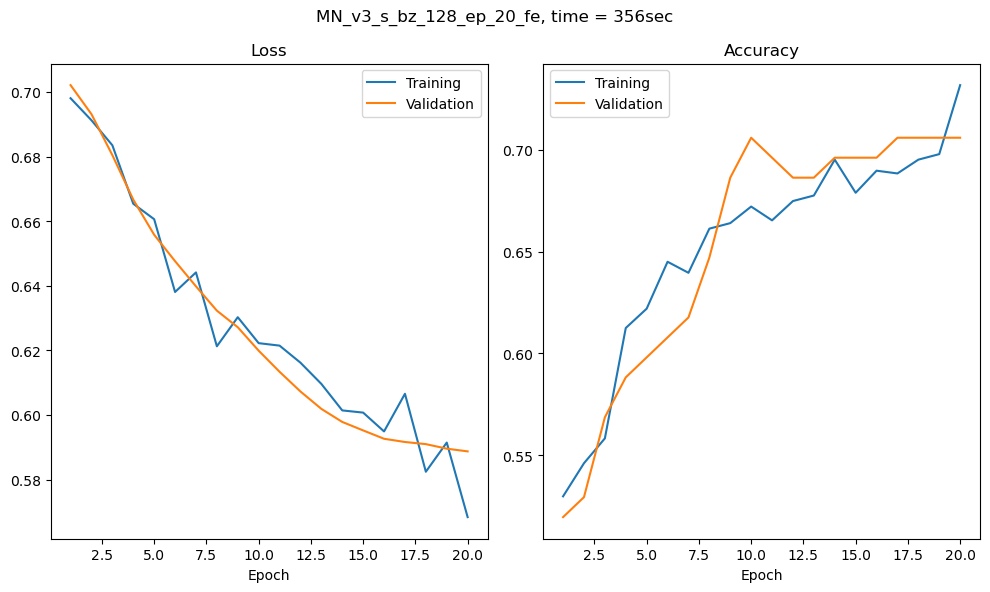

-------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------
Model descriptor: MN_v3_s_bz_32_ep_20_fe


Validation accuracy: 0.71


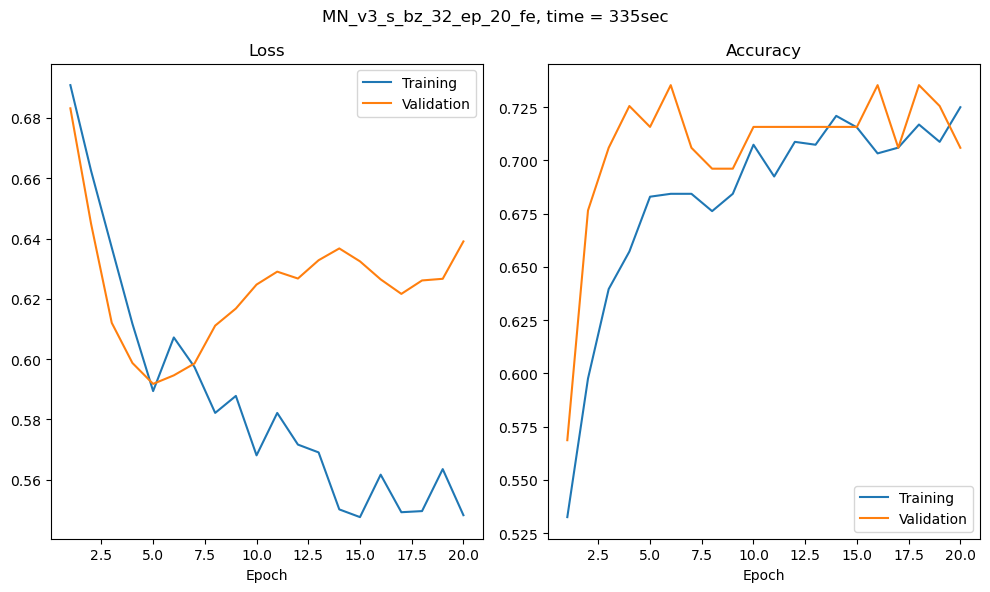

-------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------
Model descriptor: MN_v3_s_bz_64_ep_20_fe


Validation accuracy: 0.74


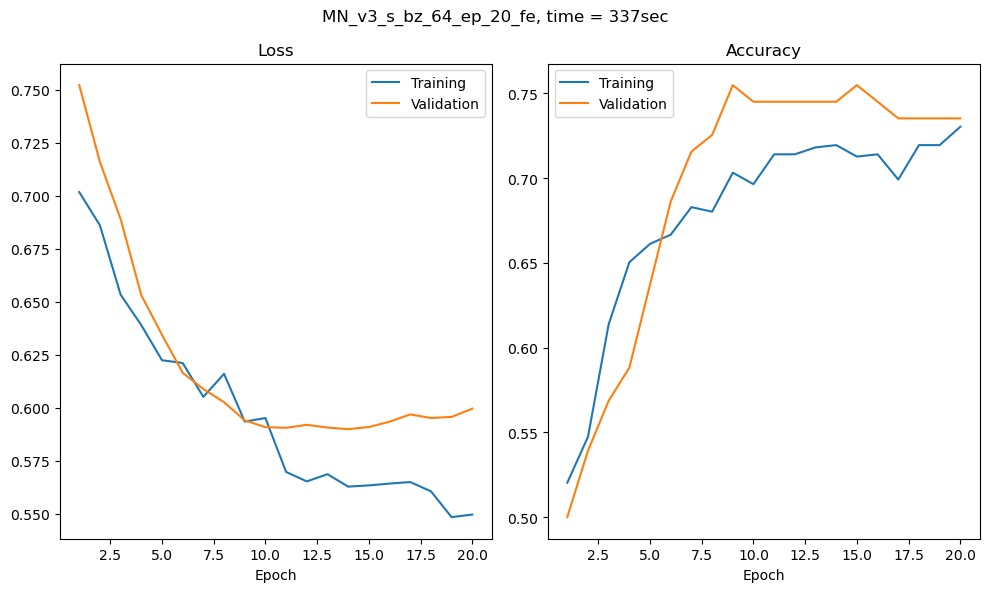

-------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------
Model descriptor: MN_v3_s_bz_64_ep_20_fe_dora


Validation accuracy: 0.71


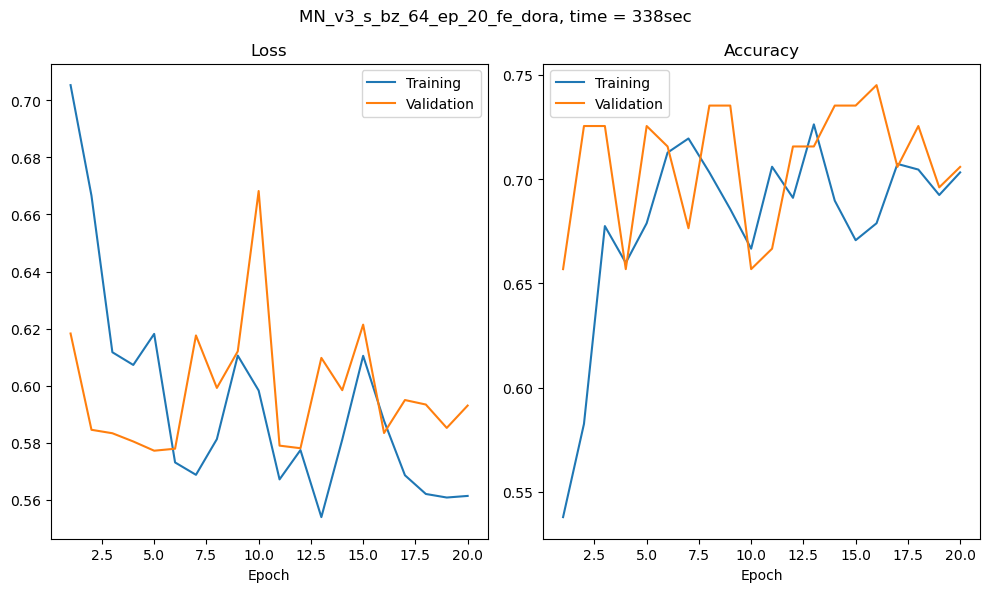

-------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------
Model descriptor: MN_v3_s_bz_64_ep_20_fe_lora


Validation accuracy: 0.73


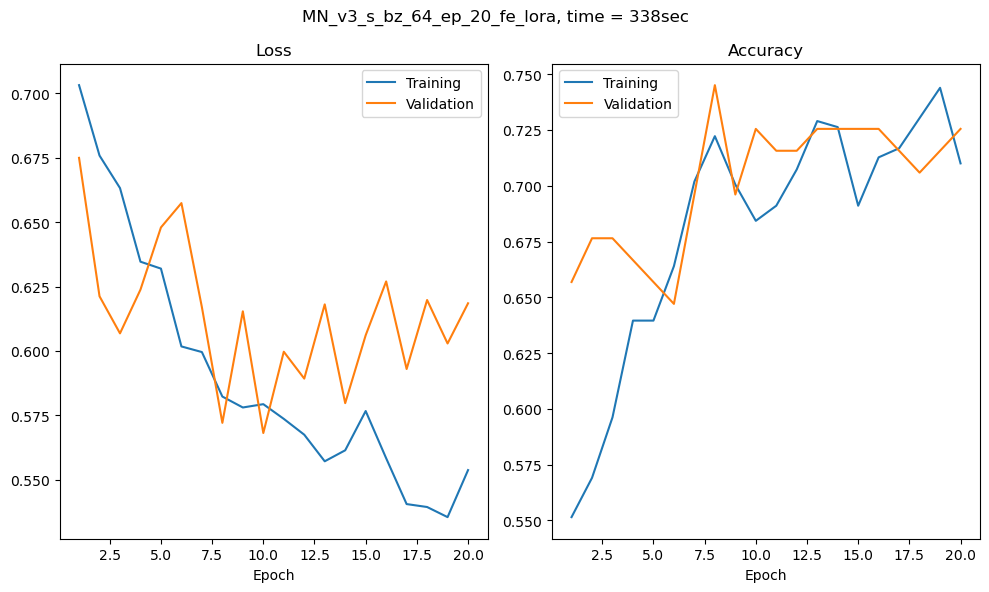

-------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------
Model descriptor: MN_v3_s_bz_64_ep_20_ft


Validation accuracy: 0.74


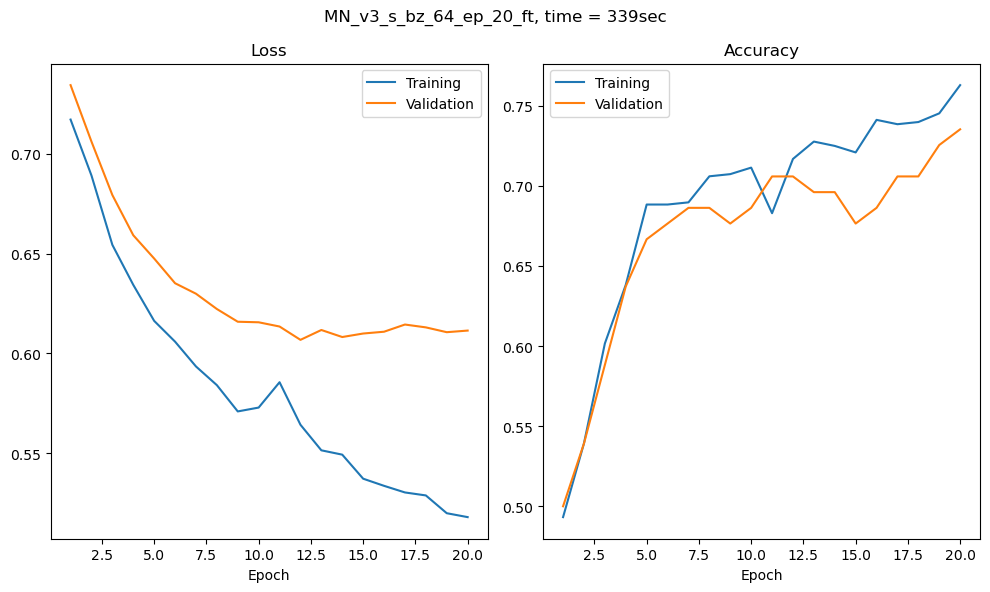

-------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------
Model descriptor: RN50_bz_128_ep_20_fe


Validation accuracy: 0.66


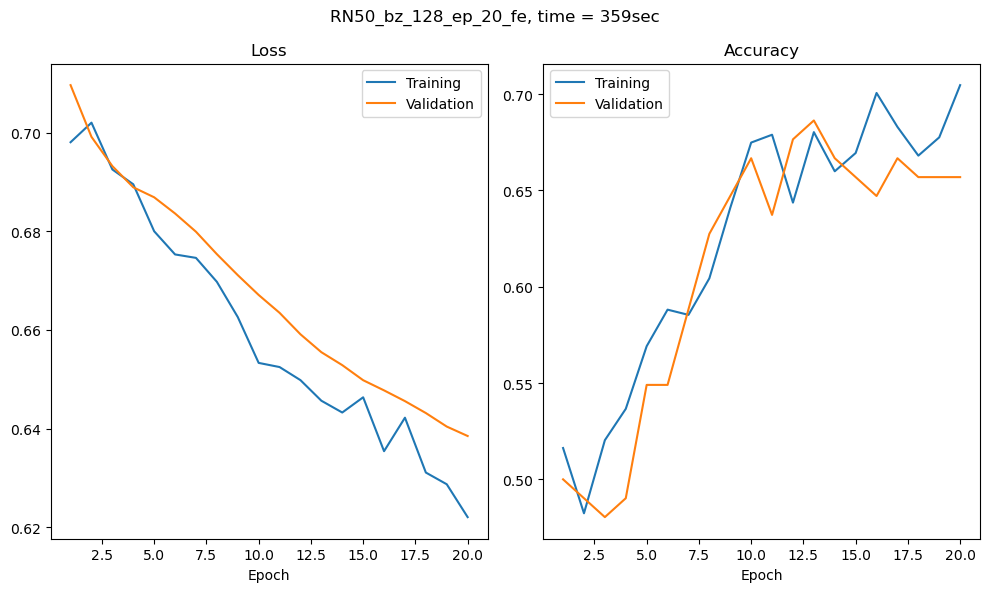

-------------------------------------------------------------------------------------------------------------------


In [21]:
# # loop over all the models and plot the training and validation loss and accuracy
histories_files_names = os.listdir(histories_save_dir)
for history_file_name in histories_files_names:
    print("-------------------------------------------------------------------------------------------------------------------")
    model_descriptor = history_file_name.split("history_")[-1].split('.')[0]
    # remove the last string after the last "_" from model model_descriptor
    model_descriptor_parts = model_descriptor.split("_")[:-1]
    model_descriptor = "_".join(model_descriptor_parts)
    print(f"Model descriptor: {model_descriptor}")
    print("\n")
    # find a history file name which contains the model descriptor  
    # history_file_name = [f for f in os.listdir(histories_save_dir) if model_descriptor in f][0]
    # if history_file_name is None:
    #     print("History file not found")
    #     continue
    model_time = history_file_name.split("_")[-1].split(".")[0]
    history_save_path = os.path.join(histories_save_dir, history_file_name)
    history = pd.read_csv(history_save_path)
    title = model_descriptor + ", time = " + str(model_time) + "sec"
    print(f"Validation accuracy: {history['val_acc'].values[-1]:.2f}")
    plot_test_results([history["train_loss"], history["train_acc"], history["val_loss"], history["val_acc"]], title)
    
    print("-------------------------------------------------------------------------------------------------------------------")

In [22]:
# load the best model
best_cnn_fe_model_name = best_cnn_fe_model_descriptor.split("_bz")[0]
print("The best model is: ", best_cnn_fe_model_name)
print("Loading the best model...")
best_model_save_name = "model_" + best_cnn_fe_model_descriptor + ".pth"
best_model_save_path = os.path.join(models_save_dir, best_model_save_name)


The best model is:  MN_v3_s
Loading the best model...


In [23]:
# testing function
def test_model(model, test_loader, criterion, optimizer, num_epochs=25):
    running_loss = 0.0
    running_corrects = 0

    # Iterate over data
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward
        with torch.set_grad_enabled(False):
            # Get model outputs and calculate loss
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    loss = running_loss / len(test_loader.dataset)
    acc = running_corrects.double() / len(test_loader.dataset)

    print('Test Loss: {:.4f} Acc: {:.4f}'.format(loss, acc))

    return loss, acc

Test results for the best model MN_v3_s_bz_64_ep_20_fe
Test Loss: 0.4340 Acc: 0.8564


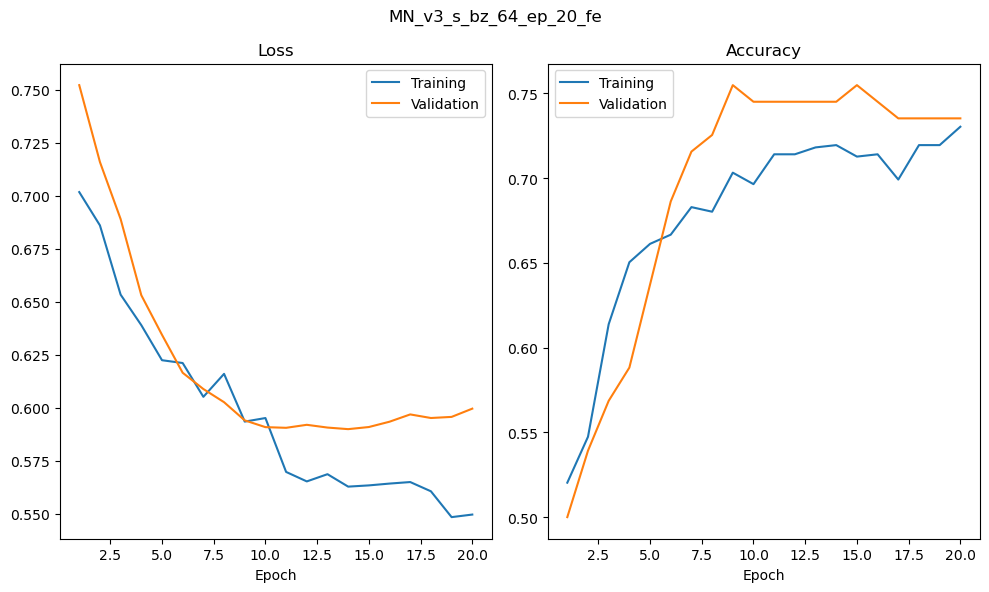

In [24]:
# Evaluate on the test set
criterion = nn.CrossEntropyLoss()
print("Test results for the best model", best_cnn_fe_model_descriptor)
best_model_num_epochs = len(best_cnn_fe_history[0])
test_loss, test_acc = test_model(best_cnn_fe_model, best_cnn_fe_dataloader['test'], criterion, best_cnn_fe_model_optimizer, num_epochs=best_model_num_epochs)

plot_test_results(best_cnn_fe_history, best_cnn_fe_model_descriptor)